https://docs.devicehive.com/v2.0/blog/using-gpus-for-training-tensorflow-models

In [9]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Image
from pandas import get_dummies
from sklearn.cross_validation import train_test_split
# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

C:\Users\vitor\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [11]:
data = pd.read_csv('../data/Iris.csv', index_col = 0)
data.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
Id,,,,,
1,5.1,3.5,1.4,0.2,Iris-setosa
2,4.9,3.0,1.4,0.2,Iris-setosa
3,4.7,3.2,1.3,0.2,Iris-setosa
4,4.6,3.1,1.5,0.2,Iris-setosa
5,5.0,3.6,1.4,0.2,Iris-setosa


In [12]:
data.shape

(150, 5)

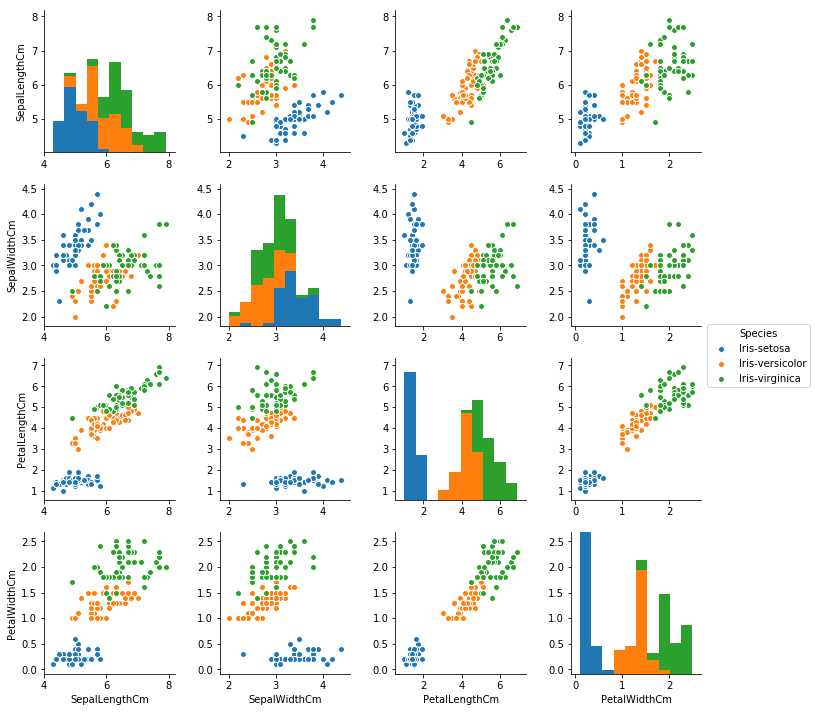

In [13]:
# Visualize data with Seaborn
g=sns.pairplot(data, hue="Species", size= 2.5)

In [14]:
cols = data.columns
features = cols[0:4]
labels = cols[4]
print(features)
print(labels)

Index(['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm'], dtype='object')
Species


In [15]:
#Well conditioned data will have zero mean and equal variance
#We get this automattically when we calculate the Z Scores for the data

data_norm = pd.DataFrame(data)

for feature in features:
    data[feature] = (data[feature] - data[feature].mean())/data[feature].std()

#Show that should now have zero mean
print("Averages")
print(data.mean())

print("\n Deviations")
#Show that we have equal variance
print(pow(data.std(),2))

Averages
SepalLengthCm   -5.684342e-16
SepalWidthCm    -6.158037e-16
PetalLengthCm    1.894781e-16
PetalWidthCm    -1.894781e-16
dtype: float64

 Deviations
SepalLengthCm    1.0
SepalWidthCm     1.0
PetalLengthCm    1.0
PetalWidthCm     1.0
dtype: float64


In [16]:
#Shuffle The data
indices = data_norm.index.tolist()
indices = np.array(indices)
np.random.shuffle(indices)
X = data_norm.reindex(indices)[features]
y = data_norm.reindex(indices)[labels]

In [17]:
# One Hot Encode as a dataframe
y = get_dummies(y)

# Generate Training and Validation Sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.3)

# Convert to np arrays so that we can use with TensorFlow
X_train = np.array(X_train).astype(np.float32)
X_test  = np.array(X_test).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)
y_test  = np.array(y_test).astype(np.float32)

In [18]:
#Check to make sure split still has 4 features and 3 labels
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(105, 4) (105, 3)
(45, 4) (45, 3)


In [21]:
training_size = X_train.shape[1]
test_size = X_test.shape[1]
num_features = 4
num_labels = 3

num_hidden = 10

graph = tf.Graph()
with graph.as_default():
    tf_train_set    = tf.constant(X_train)
    tf_train_labels = tf.constant(y_train)
    tf_valid_set    = tf.constant(X_test)
 
    
    print(tf_train_set)
    print(tf_train_labels)
    
    ## Note, since there is only 1 layer there are actually no hidden layers... but if there were
    ## there would be num_hidden
    weights_1 = tf.Variable(tf.truncated_normal([num_features, num_hidden]))
    weights_2 = tf.Variable(tf.truncated_normal([num_hidden, num_labels]))
    ## tf.zeros Automaticaly adjusts rows to input data batch size
    bias_1 = tf.Variable(tf.zeros([num_hidden]))
    bias_2 = tf.Variable(tf.zeros([num_labels]))
    
    
    logits_1 = tf.matmul(tf_train_set , weights_1 ) + bias_1
    rel_1 = tf.nn.relu(logits_1)
    logits_2 = tf.matmul(rel_1, weights_2) + bias_2
    
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits_2, tf_train_labels))
    optimizer = tf.train.GradientDescentOptimizer(.005).minimize(loss)
    
    
    ## Training prediction
    predict_train = tf.nn.softmax(logits_2)
    
    
    # Validation prediction
    logits_1_val = tf.matmul(tf_valid_set, weights_1) + bias_1
    rel_1_val    = tf.nn.relu(logits_1_val)
    logits_2_val = tf.matmul(rel_1_val, weights_2) + bias_2
    predict_valid = tf.nn.softmax(logits_2_val)

Tensor("Const:0", shape=(105, 4), dtype=float32)
Tensor("Const_1:0", shape=(105, 3), dtype=float32)


ValueError: Only call `softmax_cross_entropy_with_logits` with named arguments (labels=..., logits=..., ...)

In [20]:
# Implementation of a simple MLP network with one hidden layer. Tested on the iris data set.
# Requires: numpy, sklearn>=0.18.1, tensorflow>=1.0

# NOTE: In order to make the code simple, we rewrite x * W_1 + b_1 = x' * W_1'
# where x' = [x | 1] and W_1' is the matrix W_1 appended with a new row with elements b_1's.
# Similarly, for h * W_2 + b_2
import tensorflow as tf
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42
tf.set_random_seed(RANDOM_SEED)


def init_weights(shape):
    """ Weight initialization """
    weights = tf.random_normal(shape, stddev=0.1)
    return tf.Variable(weights)

def forwardprop(X, w_1, w_2):
    """
    Forward-propagation.
    IMPORTANT: yhat is not softmax since TensorFlow's softmax_cross_entropy_with_logits() does that internally.
    """
    h    = tf.nn.sigmoid(tf.matmul(X, w_1))  # The \sigma function
    yhat = tf.matmul(h, w_2)  # The \varphi function
    return yhat

def get_iris_data():
    """ Read the iris data set and split them into training and test sets """
    iris   = datasets.load_iris()
    data   = iris["data"]
    target = iris["target"]

    # Prepend the column of 1s for bias
    N, M  = data.shape
    all_X = np.ones((N, M + 1))
    all_X[:, 1:] = data

    # Convert into one-hot vectors
    num_labels = len(np.unique(target))
    all_Y = np.eye(num_labels)[target]  # One liner trick!
    return train_test_split(all_X, all_Y, test_size=0.33, random_state=RANDOM_SEED)

def main():
    train_X, test_X, train_y, test_y = get_iris_data()

    # Layer's sizes
    x_size = train_X.shape[1]   # Number of input nodes: 4 features and 1 bias
    h_size = 256                # Number of hidden nodes
    y_size = train_y.shape[1]   # Number of outcomes (3 iris flowers)

    # Symbols
    X = tf.placeholder("float", shape=[None, x_size])
    y = tf.placeholder("float", shape=[None, y_size])

    # Weight initializations
    w_1 = init_weights((x_size, h_size))
    w_2 = init_weights((h_size, y_size))

    # Forward propagation
    yhat    = forwardprop(X, w_1, w_2)
    predict = tf.argmax(yhat, axis=1)

    # Backward propagation
    cost    = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=yhat))
    updates = tf.train.GradientDescentOptimizer(0.01).minimize(cost)

    # Run SGD
    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)

    for epoch in range(100):
        # Train with each example
        for i in range(len(train_X)):
            sess.run(updates, feed_dict={X: train_X[i: i + 1], y: train_y[i: i + 1]})

        train_accuracy = np.mean(np.argmax(train_y, axis=1) ==
                                 sess.run(predict, feed_dict={X: train_X, y: train_y}))
        test_accuracy  = np.mean(np.argmax(test_y, axis=1) ==
                                 sess.run(predict, feed_dict={X: test_X, y: test_y}))

        print("Epoch = %d, train accuracy = %.2f%%, test accuracy = %.2f%%"
              % (epoch + 1, 100. * train_accuracy, 100. * test_accuracy))

    sess.close()

if __name__ == '__main__':
    main()

InvalidArgumentError: Cannot assign a device for operation 'random_uniform_3/sub': Operation was explicitly assigned to /device:GPU:1 but available devices are [ /job:localhost/replica:0/task:0/cpu:0, /job:localhost/replica:0/task:0/gpu:0 ]. Make sure the device specification refers to a valid device.
	 [[Node: random_uniform_3/sub = Sub[T=DT_HALF, _device="/device:GPU:1"](random_uniform_3/max, random_uniform_3/min)]]

Caused by op 'random_uniform_3/sub', defined at:
  File "C:\Users\vitor\Anaconda3\envs\deeplearning\lib\runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\vitor\Anaconda3\envs\deeplearning\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\vitor\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\vitor\Anaconda3\envs\deeplearning\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\vitor\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\vitor\Anaconda3\envs\deeplearning\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\vitor\Anaconda3\envs\deeplearning\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\vitor\Anaconda3\envs\deeplearning\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\vitor\Anaconda3\envs\deeplearning\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\vitor\Anaconda3\envs\deeplearning\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\vitor\Anaconda3\envs\deeplearning\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\vitor\Anaconda3\envs\deeplearning\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\vitor\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\vitor\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\vitor\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\vitor\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\vitor\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\vitor\Anaconda3\envs\deeplearning\lib\site-packages\IPython\core\interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\vitor\Anaconda3\envs\deeplearning\lib\site-packages\IPython\core\interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\vitor\Anaconda3\envs\deeplearning\lib\site-packages\IPython\core\interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-fa5a2096b436>", line 40, in <module>
    device_times, matrix_sizes = get_times(1.5)
  File "<ipython-input-8-fa5a2096b436>", line 23, in get_times
    r2 = tf.random_uniform(shape=shape, minval=0, maxval=1, dtype=data_type)
  File "C:\Users\vitor\Anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\ops\random_ops.py", line 241, in random_uniform
    return math_ops.add(rnd * (maxval - minval), minval, name=name)
  File "C:\Users\vitor\Anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\ops\math_ops.py", line 865, in binary_op_wrapper
    return func(x, y, name=name)
  File "C:\Users\vitor\Anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\ops\gen_math_ops.py", line 2629, in _sub
    result = _op_def_lib.apply_op("Sub", x=x, y=y, name=name)
  File "C:\Users\vitor\Anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "C:\Users\vitor\Anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\framework\ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Users\vitor\Anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\framework\ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Cannot assign a device for operation 'random_uniform_3/sub': Operation was explicitly assigned to /device:GPU:1 but available devices are [ /job:localhost/replica:0/task:0/cpu:0, /job:localhost/replica:0/task:0/gpu:0 ]. Make sure the device specification refers to a valid device.
	 [[Node: random_uniform_3/sub = Sub[T=DT_HALF, _device="/device:GPU:1"](random_uniform_3/max, random_uniform_3/min)]]
